# Baseline Experiment 2: Training Random Forest Classifier

Using Grid Search with 5-fold Cross-Validation, with a 70/30 train/test split.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight  # For balanced class weighted classification training

# For reproducible results
RANDOM_STATE_SEED = 420
df_dataset = pd.read_csv("processed_Infilteration_2.csv")
df_dataset.info()
df_dataset = df_dataset.drop(['Timestamp'], axis=1)
df_dataset.info()
### 1- Making an 70/30 train/test split
train, test = train_test_split(df_dataset, test_size=0.3, random_state=RANDOM_STATE_SEED)
train
test
#### MinMax Scaling of numerical attributes
numerical_cols = train.columns[:-3]
numerical_cols
min_max_scaler = MinMaxScaler().fit(train[numerical_cols])
train[numerical_cols] = min_max_scaler.transform(train[numerical_cols])
train
test[numerical_cols] = min_max_scaler.transform(test[numerical_cols])
test
### 2- Checking label distribution

In [35]:
print("Full dataset:\n")
print("Benign: " + str(df_dataset["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(df_dataset["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Training set:\n")
print("Benign: " + str(train["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(train["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Test set:\n")
print("Benign: " + str(test["Label"].value_counts()[[0]].sum()))
print("Malicious: " + str(test["Label"].value_counts()[[1]].sum()))

Full dataset:

Benign: 538508
Malicious: 68858
---------------
Training set:

Benign: 376687
Malicious: 48469
---------------
Test set:

Benign: 161821
Malicious: 20389


### 3- Splitting to X_train, y_train, X_test, y_test

In [36]:
y_train = np.array(train.pop("Label")) # pop removes "Label" from the dataframe
X_train = train.values

print(type(X_train))
print(type(y_train))
print(X_train.shape)
print(y_train.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(425156, 77)
(425156,)


In [37]:
y_test = np.array(test.pop("Label")) # pop removes "Label" from the dataframe
X_test = test.values

print(type(X_test))
print(type(y_test))
print(X_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(182210, 77)
(182210,)


### 4- Fitting Random Forest model

In [38]:
# Calculating class weights for balanced class weighted classifier training
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

print(class_weights)

# Must be in dict format for scikitlearn
class_weights = {
    0: class_weights[0],
    1: class_weights[1]
}

print(class_weights)

[0.56433591 4.38585488]
{0: 0.5643359075306554, 1: 4.3858548763126946}


In [42]:
model = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=class_weights,
    ccp_alpha=0.0,
    max_samples=None
)

hyperparameters = {
    'n_estimators': [50, 75, 100, 125, 150]
}

In [43]:
clf = GridSearchCV(
    estimator=model,
    param_grid=hyperparameters,
    cv=5,
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

In [44]:
clf.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


d:\final year project-nids\copy-dataset\final_project\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 0.5643359075306554,
                                                            1: 4.3858548763126946},
                                              max_features='auto'),
             n_jobs=-1, param_grid={'n_estimators': [50, 75, 100, 125, 150]},
             verbose=1)

In [47]:
fold_accuracies = clf.cv_results_['mean_test_score']
print(fold_accuracies)

[0.76194856 0.75993047 0.76106652 0.7608125  0.75998692]


### 5- Extracting best performing model in the 5-fold cross-validation Grid Search

In [48]:
print("Accuracy score on Validation set: \n")
print(clf.best_score_ )
print("---------------")
print("Best performing hyperparameters on Validation set: ")
print(clf.best_params_)
print("---------------")
print(clf.best_estimator_)

Accuracy score on Validation set: 

0.7619485566817994
---------------
Best performing hyperparameters on Validation set: 
{'n_estimators': 50}
---------------
RandomForestClassifier(class_weight={0: 0.5643359075306554,
                                     1: 4.3858548763126946},
                       max_features='auto', n_estimators=50)


In [49]:
model = clf.best_estimator_

In [50]:
model

RandomForestClassifier(class_weight={0: 0.5643359075306554,
                                     1: 4.3858548763126946},
                       max_features='auto', n_estimators=50)

### 6- Evaluating on Test set

In [51]:
predictions = model.predict(X_test)

In [52]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

#### 6.1 Accuracy on Test set

In [53]:
print(accuracy_score(y_test, predictions))

0.7506668130179464


#### 6.2 Confusion matrix

In [54]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[132881  28940]
 [ 16491   3898]]


/home/tamer/anaconda3/envs/cic-ids-2018/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


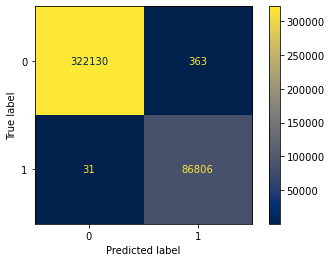

In [28]:
plot_confusion_matrix(model, X_test, y_test, cmap="cividis")

#### 6.3 Classification report

In [29]:
print(classification_report(y_test, predictions, digits=5))

              precision    recall  f1-score   support

           0    0.99990   0.99887   0.99939    322493
           1    0.99584   0.99964   0.99774     86837

    accuracy                        0.99904    409330
   macro avg    0.99787   0.99926   0.99856    409330
weighted avg    0.99904   0.99904   0.99904    409330



### 7- Saving model

In [30]:
joblib.dump(model, "trained_models/random-forest-classifier.pkl")

['trained_models/random-forest-classifier.pkl']

### 8- Testing loading model

In [31]:
model = joblib.load("trained_models/random-forest-classifier.pkl")

In [32]:
model

RandomForestClassifier(class_weight={0: 0.6351680989134786,
                                     1: 2.3495488359278136},
                       n_estimators=125)